In [2]:
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from IPython import display
from common import *

np.random.seed(123)
tf.random.set_random_seed(123)

In [40]:
def make_spirals(n_samples):
    n = np.sqrt(np.random.rand(n_samples // 2)) * 540 * (2 * np.pi) / 360
    d1x = - np.cos(n) * n + np.random.rand(n_samples // 2) * 0.5
    d1y =   np.sin(n) * n + np.random.rand(n_samples // 2) * 0.5
    x = np.concatenate([np.stack([ d1x,  d1y], axis=1),
                       np.stack([-d1x, -d1y], axis=1)]) / 3

    x = (x - x.min())/(x - x.min()).max()
    x = (x - 0.5)*0.5 + 0.5
    return x

In [33]:

x_train, y_train = make_dataset(make_spirals, n_pos_samples=1000, n_neg_samples=300)
tf.reset_default_graph()
detector = Model(var_scope='detector', hidden_sizes=[500]*5)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='detector')

x_train_others = x_train[y_train == 0]
x_train_target = x_train[y_train == 1]
y_train_others = y_train[y_train == 0]
y_train_target = y_train[y_train == 1]

attack = PGDAttackDetector(detector, **attack_config, batch_size=x_train_others.shape[0])


In [34]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [35]:
optimizer = tf.train.AdamOptimizer(5e-4)
train_step = optimizer.minimize(detector.xent)
sess.run(tf.variables_initializer(optimizer.variables()))

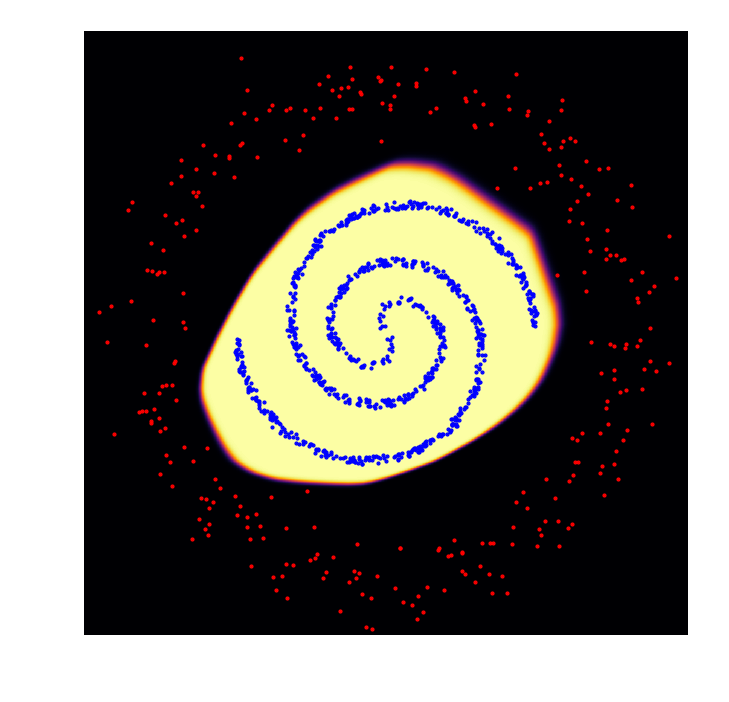

In [36]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

for i in range(500):
    sess.run(train_step,feed_dict={detector.x_input: x_train, detector.y_input: y_train})
plot_detector(detector, x_train, y_train, ax, sess)
plt.show()

In [37]:
for i in range(15000):
    x_train_others_adv = attack.perturb(x_train_others, None, sess, verbose=False)
    x_train_with_adv = np.concatenate([x_train_target, x_train_others_adv])
    y_train_with_adv = np.concatenate([y_train_target, y_train_others])
    sess.run(train_step,feed_dict={detector.x_input: x_train_with_adv, detector.y_input: y_train_with_adv})

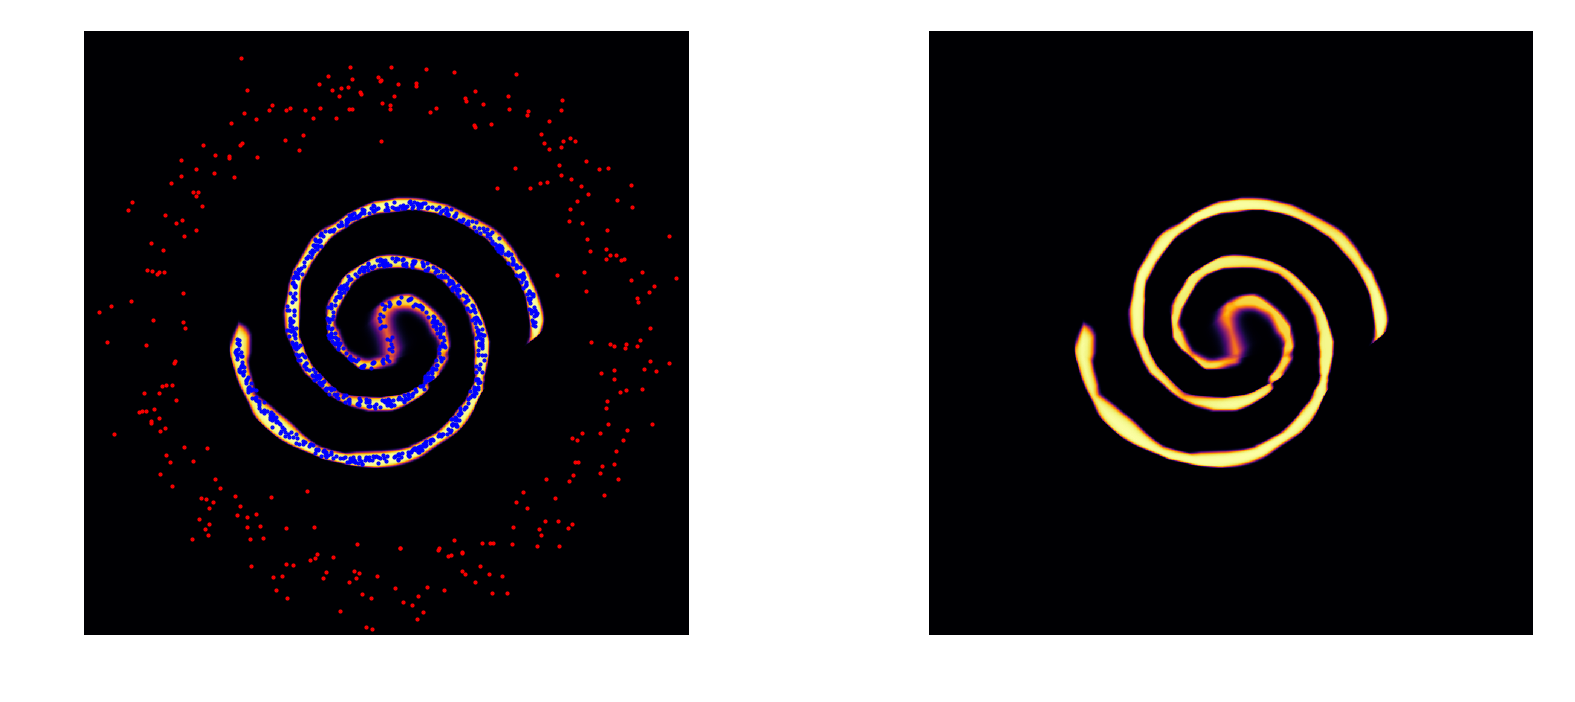

In [38]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 4), dpi=200)
plot_detector(detector, x_train, y_train, ax0, sess)
plot_detector(detector, x=None, y=None, ax=ax1, sess=sess)
plt.show()